In [1]:
import pandas as pd
from utils import read_data
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt
from time import time
from typing import List
import warnings
import optuna
from optuna.samplers import TPESampler

pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 150)

warnings.filterwarnings("ignore", category=UserWarning)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Our task

In this activity, we're asked to "[look] for accident / fatality risk factors, and [provide] an understanding of the factors that contribute to accidents and the severity of accidents." Examples include location, time of day, weather, road surfaces, etc. To answer these questions we are to use road accident and safety data from Great Britain, which can be found [here](https://www.data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data). We're to create a Jupyter Notebook presenting these findings, communicating these suggested improvements to the Department of Transport. Additionally, if we're able, we are to provide information to car manufacturers to improve their products.

# Modeling strategy

Implicitly, this asks us to create a causal model of the factors leading to an accident or fatality. However, **we lack a plausible exogenous source of variation from which a causal effect could be identified** (for more, [see](https://en.wikipedia.org/wiki/Endogeneity_(econometrics))). For this reason I interpret model results as **correlational, not causal**.

This task is also distinctly different from classical machine learning modeling efforts, where **prediction** is chiefly of interest. **Rather, we are interested in model coefficients** à la regression analysis. 

To satisfy this task, I take a somewhat different approach using a machine learning model ([light gradient boosted machines or LGBM](https://lightgbm.readthedocs.io/en/stable/)) combined with an explanation algorithm, [SHapley Additive exPlanations or SHAP](https://shap.readthedocs.io/en/latest/). 

Compared to traditional regression analysis, where the analyst must a-priori specify the structural causal model, this ML model more flexibly models the outcome variable, enabling it to better align with the population data generating process. SHAP values explain or "credit" the model's prediction to the features included in the model, thereby not only demystifying the traditional "black-box" nature of ML, but also offering an analygous concept to a regression coefficient. Rather than offering a "global" explanation of which features were important to the model as a whole (e.g. XGBoost's `get_scores` method), **SHAP values quantify the effect of features on an individual observation's prediction**, enabling e.g. highly detailed subgroup analysis.

### Model interpretation

The outcome variable I use (see below) **explicitly models the severity of the accident for a given vehicle, examining which features matter most in predicting this severity. In our case "severity" is a binary indicator whether an accident yielded no/slight injuries versus severe/fatal injuries**.

# 1.0 Data

I use data from the most recent three years (2019 - 2021). By including the year 2019, I hope to somewhat offset the irregular traffic and commuting patterns caused by the Corona virus. Older years of data, going back to 1979. are available; however, I prefer to use only newer data in order to examine accident/fatality factors among newer vehicles.

These **data are hierarchical in nature**, presenting some initial modeling and data challenges in their raw form. There are **three distinct entities** and corresponding datasets: **accidents** (i.e. general information where, when, and why), **vehicles** (i.e. cars, vans, buses, trollies, bicycles, and other [horses, farm tractors] involved in an accident), and **casualties** (i.e. within a particular vehicle but also potentially pedestrians struck by a vehicle). Casualties are nested within vehicles, which in turn are nested within accidents. 

Importantly, some vehicles involved in an accident have no casualties (i.e. they have no match in the casualty dataset). I include these vehicles in the analysis as a ba

### 1.1 Data preprocessing

I use **vehicles as the level of analysis**, aggregating casualty information up to the vehicle level (e.g. total casualties, mean age of casualties, share male) and merge this onto the vehicle file. In a final step, I merge the accident data onto the vehicle file. 

Because substantial data preprocessing was required, I outsourced this several functions in `utils.py`. In addition to data restructuring, I drop several features that I suspect have no causal effect on the outcome, recode unknown category values to missing, engineer some new datetime features, consolidate the number of distinct vehicle types from 22 to 9. 

Importantly, **some vehicles involved in an accident have no casualties** (i.e. they have no match in the casualty dataset), **which I combine together with an existing accident severity class, "slight injury", in the outcome feature** (see below).

### 1.2 Outcome feature

**I create a new binary outcome feature, `casualty_worst`, which represents the *worst casualty* attributed to a particular vehicle in a particular accident**. Casualties can partain to vehicle occupants or pedestrians struck by the vehicle (bicycles are also counted as vehicles). **This feature does not differentiate between the number of casualties associated with a vehicle**. I use this new outcome feature in all modeling efforts below.

To create this new outcome feature I start with the the feature, `casualty_severity`, in the casualty dataset, which contains three classes of casualty severity: "slight", "severe", or "fatal". **I combine "non-injury" vehicles (see above) with slight injury vehicles as the baseline class (=0). I also combine "serious" and "fatal" together as the other class (=1)**. Combining casualty classes in this way simplifies the analytic step I take below, and also strongly bolsters the frequency of the class coded 1 since fatalities are extremely rare in the data.

This new outcome is coded as such:

0) **non-injury*** or slight injury
1) serious injury or fatality

\* New category, created for vehicles in an accident with no casualties

In [2]:
df = read_data()

In [3]:
print(df.casualty_worst.value_counts().sort_index())
print('\n', df.casualty_worst.value_counts(normalize=True).sort_index())

0    500841
1     69332
Name: casualty_worst, dtype: int64

 0    0.878402
1    0.121598
Name: casualty_worst, dtype: float64


### 1.3 EDA 

In [4]:
df.head()

,accident_year,accident_reference,vehicle_reference,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_location_restricted_lane,junction_location,skidding_and_overturning,hit_object_in_carriageway,vehicle_leaving_carriageway,hit_object_off_carriageway,first_point_of_impact,vehicle_left_hand_drive,journey_purpose_of_driver,sex_of_driver,age_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,driver_imd_decile,driver_home_area_type,casualty_class_0,casualty_class_1,casualty_class_2,casualty_class_3,casualty_severity_1,casualty_severity_2,casualty_severity_3,casualty_severity_4,casualty_worst,casualty_share_male,casualty_mean_age,casualty_total,longitude,latitude,number_of_vehicles,local_authority_district,first_road_class,road_type,speed_limit,junction_detail,junction_control,second_road_class,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,datetime,month,day,dayw,hour,elapsed_time
0,2019,010128300,1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,1.0,58.0,NaN,NaN,NaN,2.0,1.0,0,1,2,0,0,0,3,0,0,0.333333,58.0,3,-0.153842,51.508057,2,1.0,3,1.0,30.0,1.0,2.0,3.0,1.0,1.0,1.0,0.0,0.0,1,2019-02-18 17:50:00,2,18,0,17,4211040.0
1,2019,010128300,2,9.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,1,0,0,0,0,0,0,1,0,NaN,NaN,1,-0.153842,51.508057,2,1.0,3,1.0,30.0,1.0,2.0,3.0,1.0,1.0,1.0,0.0,0.0,1,2019-02-18 17:50:00,2,18,0,17,4211040.0
2,2019,010152270,1,9.0,0.0,18.0,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2.0,24.0,NaN,NaN,NaN,3.0,1.0,0,1,0,0,0,0,1,0,0,0.000000,24.0,1,-0.127949,51.436208,2,9.0,3,2.0,30.0,0.0,NaN,NaN,4.0,1.0,1.0,0.0,0.0,1,2019-01-15 21:45:00,1,15,1,21,1287540.0
3,2019,010152270,2,9.0,0.0,18.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,1.0,1,0,0,0,0,0,0,1,0,NaN,NaN,1,-0.127949,51.436208,2,9.0,3,2.0,30.0,0.0,NaN,NaN,4.0,1.0,1.0,0.0,0.0,1,2019-01-15 21:45:00,1,15,1,21,1287540.0
4,2019,010155191,1,9.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,NaN,1.0,45.0,NaN,NaN,NaN,4.0,1.0,1,0,0,0,0,0,0,1,0,NaN,NaN,1,-0.124193,51.526795,2,2.0,4,6.0,30.0,3.0,4.0,6.0,4.0,1.0,1.0,0.0,0.0,1,2019-01-01 01:50:00,1,1,1,1,6240.0


In [5]:
df.shape

(570173, 56)

In [6]:
df['accident_year'].value_counts().sort_index()

2019    216381
2020    167349
2021    186443
Name: accident_year, dtype: int64

In [7]:
df_summary = df.isnull().mean()
df_summary = pd.concat([df_summary, df.dtypes], axis=1)
df_summary.rename(columns={0: 'share_missing', 1: 'dtype'})

,share_missing,dtype
accident_year,0.000000,int64
accident_reference,0.000000,object
vehicle_reference,0.000000,int64
vehicle_type,0.000631,float64
towing_and_articulation,0.024428,float64
vehicle_manoeuvre,0.075167,float64
vehicle_location_restricted_lane,0.072962,float64
junction_location,0.055402,float64
skidding_and_overturning,0.075931,float64
hit_object_in_carriageway,0.074456,float64


# 2.0 ML Model

LightGBM is a gradient boosting framework that uses tree based learning algorithms for raking, classiciation, and regression. Importantly, LightGBM differs from other gradient boosted decision tree frameworks (e.g. XGBoost) in that trees are grown leaf-wise, rather than level-wise. 

### 2.1 Preprocessing for modeling

LightGBM importantly needs to know which features are categorical versus numeric. In earlier preprocessing stages we ensured categorical features had numeric representations (a requirement of LGBM). Below we create lists for each feature type to provide to the LGBM data object at instantiation.

In [8]:
data_config = {
            'categorical_features': [
                    'vehicle_type',
                    'towing_and_articulation',
                    'vehicle_manoeuvre',
                    'junction_location',
                    'skidding_and_overturning',
                    'hit_object_in_carriageway',
                    'vehicle_leaving_carriageway',
                    'hit_object_off_carriageway',
                    'first_point_of_impact',
                    'vehicle_left_hand_drive',
                    'journey_purpose_of_driver',
                    'sex_of_driver',
                    'propulsion_code',
                    'driver_imd_decile',
                    'driver_home_area_type',
                    'local_authority_district',
                    'first_road_class',
                    'road_type',
                    'junction_detail',
                    'junction_control',
                    'second_road_class',
                    'light_conditions',
                    'weather_conditions',
                    'road_surface_conditions',
                    'special_conditions_at_site',
                    'carriageway_hazards',
                    'urban_or_rural_area'
            ],
    
            'numeric_features': [
                    'accident_year',
                    'month',
                    'day',
                    'dayw',
                    'hour',
                    'elapsed_time',
                    'age_of_driver',
                    'engine_capacity_cc',
                    'age_of_vehicle',
                    'casualty_share_male',
                    'casualty_mean_age',
                    'longitude',
                    'latitude',
                    'number_of_vehicles',
                    'speed_limit'
                    ],
    
            'target_feature': 'casualty_worst'
        }

#### A note on feature normalization

[Feature normalization](https://en.wikipedia.org/wiki/Feature_scaling) (e.g. min-max normalization or z-score standardization) is a common practice for many ML models. Generally, this practice speeds up and stabilizes model training. However, **this data transformation is not required for tree-based models such as the one I'm using**. The reason is because tree-based models do not care about the absolute values of a feature, only the order of the values.

### 2.2 Cross-validation using holdout method

I create two different holdout cross-validation sets. First, a 5% `test` set, which I use for the SHAP values later. Second, using the remaining data, a 20% validation holdout to evaluate the hyperparameters of a given model trial (see below)

In [9]:
features = data_config['categorical_features'] + data_config['numeric_features']

# First holdout
X_train, X_test, y_train, y_test = train_test_split(df[features], 
                                                    df[data_config['target_feature']],
                                                    test_size=0.05,
                                                    random_state=123,
                                                    stratify=df[data_config['target_feature']],
                                                    shuffle=True)

# Second holdout
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, 
                                                  shuffle=True, random_state=42)

In [10]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print('\n', y_train.mean())
print(y_val.mean())
print(y_test.mean())

(433331, 42)
(108333, 42)
(28509, 42)

 0.12159757783311141
0.121597297222453
0.12161071942193694


In [11]:
# Create LGBT dataset objects

train = lgb.Dataset(data=X_train,
                    label=y_train,
                    categorical_feature=data_config['categorical_features'],
                    free_raw_data=False)

validation = lgb.Dataset(data=X_val,
                         label=y_val,
                         categorical_feature=data_config['categorical_features'],
                         free_raw_data=False)

### 2.3 Model hyperoptimization using `Optuna`

Our strategy to identify the factors predicting the severity of a vehicular accident requires that we accurately model the data generating process. To ensure our model fits the data well, I use a hyperperameter optimization framework called `Optuna`.

Optuna is an automatic hyperparameter optimization framework. It offers several optimization algorithms including grid and random search. We stick with the default [TPE (Tree-structured Parzen Estimator)](https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.TPESampler.html) algorithm.

The optimizer below seeks to find the best hyperparameter combination, where "best" is defined as the trial with the lowest binary log-loss in the validation set for that trial.

In [12]:
def objective(trial: optuna.Trial, X_train: pd.DataFrame, X_val: pd.DataFrame, 
              y_train: pd.Series, y_val: pd.Series) -> float:
    """
    Wrapper function for optuna hyperparameter optimization. 
    :param X_train: pd.DataFrame, training predictors
    :param X_val: pd.DataFrame, validation predictors
    :param y_train: pd.Series, training target
    :param y_val: pd.Series, validation target
    :return: float, binary log-loss from trial
    """
    
    # Note - LGBM seems to prefer dataset instantiation per trial, else generates errors
    train = lgb.Dataset(data=X_train,
                    label=y_train,
                    categorical_feature=data_config['categorical_features'],
                    free_raw_data=False)

    validation = lgb.Dataset(data=X_val,
                             label=y_val,
                             categorical_feature=data_config['categorical_features'],
                             free_raw_data=False)
    
    # Hyperparameters to search
    params = {
        "objective": "binary",
        "metric": ["binary_logloss"],
        "verbose": -1,
        "early_stopping_round": 5,
        "boosting_type": "gbdt",
        "num_threads": 4,
        "seed": 123,
        "num_iterations": 100,
        #"feature_pre_filter": False,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(params, train, valid_sets=[validation],
                    verbose_eval=False, keep_training_booster=True)

    loss = gbm.eval_valid()[0][2]  # binary log-loss from validation set in this trial

    return loss

In [13]:
current = time()

sampler = TPESampler(seed=10)  # ensures reproducibility
study = optuna.create_study(sampler=sampler, direction='minimize')  # note - uses median pruner by default
study.optimize(lambda trial: objective(trial, X_train, X_val, y_train, y_val), n_trials=50)

print(f"Total model hyperoptimization time: {round(time() - current, 2)} seconds. \n")

print("Number of finished trials: {}".format(len(study.trials)))

print(f"Best trial number {study.best_trial.number}")

print("Best parameters:")
best_parameters = study.best_trial.params
best_parameters

Total model hyperoptimization time: 181.25 seconds. 

Number of finished trials: 50
Best trial number 30
Best parameters:


{'lambda_l1': 1.4463949116970246e-06,
 'lambda_l2': 8.937940728714277e-07,
 'num_leaves': 109,
 'feature_fraction': 0.4618221277081178,
 'bagging_fraction': 0.9977383258138643,
 'bagging_freq': 2,
 'min_child_samples': 46}

### 2.4 Model training using best hyperparameters

Now that we have learned the optimal hyperparameters from above, we plug this into our actual model.

In [14]:
train = lgb.Dataset(data=X_train,
                    label=y_train,
                    categorical_feature=data_config['categorical_features'],
                    free_raw_data=False)

validation = lgb.Dataset(data=X_val,
                         label=y_val,
                         categorical_feature=data_config['categorical_features'],
                         free_raw_data=False)

In [15]:
# Combine best hyperparameters with other necessary model params
params = {
        "objective": "binary",
        "metric": ["binary_logloss", 'auc'],
        "verbose": -1,
        "early_stopping_round": 5,
        "boosting_type": "gbdt",
        "num_threads": 4,
        "seed": 123,
}

params = dict(params, **best_parameters)

In [16]:
current = time()

results = {}
bst = lgb.train(params, train, valid_sets=[validation],
                evals_result=results, verbose_eval=False)

print(f"Total model training time: {round(time() - current, 2)} seconds.")

Total model training time: 4.56 seconds.


### 2.5 Model performance in holdout using best hyperparameters

Figure 1 depicts the loss function, [binary cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy) in the validation set by epoch. We can see the loss continue to decrease until training was halted due to early stopping.

In order to understand Figure 2, AUC, it's necessary to first understand the [receiver operator characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). The ROC curve is an evaluation metric for binary classication problems, which plots the true positive rate (TPR) against the false positive rate (FPR) at various classification thresholds. Area under the curve (AUC) is a summary measure of the ROC, capturing the area underneath the ROC curve. Figure 2 therefore represents AUC scores in the validation set across epochs.

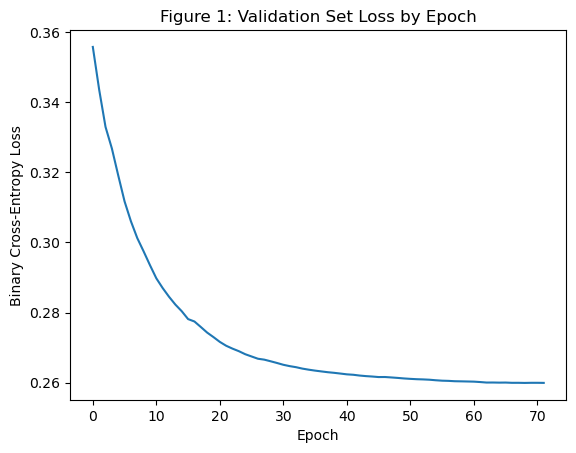

In [17]:
plt.plot(results['valid_0']['binary_logloss'])
plt.title('Figure 1: Validation Set Loss by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.show()

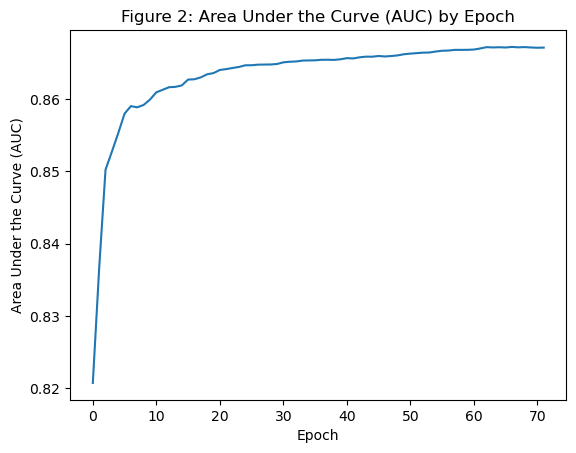

In [18]:
plt.plot(results['valid_0']['auc'])
plt.title('Figure 2: Area Under the Curve (AUC) by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Area Under the Curve (AUC)')
plt.show()